<a href="https://colab.research.google.com/github/Kartik97/ML/blob/master/a3pb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import numpy as np
# arr = np.ones(10**9, dtype='float128')

In [53]:
import numpy as np
import multiprocessing as mp
import scipy
import math  
import pandas as pd
from tqdm import tqdm
from time import time
import pickle
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import itertools
import math
from sklearn.neural_network import MLPClassifier
%matplotlib inline
mp.cpu_count()

2

In [0]:
path = "/content/drive/My Drive/Colab Notebooks/alphabet"
train = (pd.read_csv(path+"/train.csv",header=None))
test = (pd.read_csv(path+"/test.csv",header=None))
trainX = np.array(train.drop(columns=[784]))/255
trainY = np.reshape(np.array(train[784]),(-1,1))
testX = np.array(test.drop(columns=[784]))/255
testY = np.reshape(np.array(test[784]),(-1,1))

In [0]:
class NeuralNetwork:
  def __init__(self,batchSize,features,layers,classes,eta=0.1,adaptiveLearning=False,activation="sigmoid",weight_init="xavier"):
    self.batchSize = batchSize
    self.features = features
    self.classes = classes
    self.eta = eta
    self.activationFunction = activation
    self.adaptiveLearning = adaptiveLearning

    if(weight_init=="xavier"):
      self.weights = [np.random.normal(0,1/features,(features,layers[0]))]
    # self.weights = [np.random.normal(0,2/(features+layers[0]),(features,layers[0]))]
      self.bias = [np.zeros((1,layers[0]))]
    else:
      self.weights = [np.random.uniform(-0.1,0.1,(features,layers[0]))]
      self.bias = [np.random.uniform(-0.1,0.1,(1,layers[0]))]
    for i in range(1,len(layers)):
      if(weight_init=="xavier"):
        self.weights.append(np.random.normal(0,1/layers[i-1],(layers[i-1],layers[i])))
        # self.weights.append(np.random.normal(0,2/(layers[i-1]+layers[i]),(layers[i-1],layers[i])))
        self.bias.append(np.zeros((1,layers[i])))
      else:
        self.weights.append(np.random.uniform(-0.1,0.1,(layers[i-1],layers[i])))
        self.bias.append(np.random.uniform(-0.1,0.1,(1,layers[i])))
    if(weight_init=="xavier"):
      self.weights.append(np.random.normal(0,1/layers[len(layers)-1],(layers[len(layers)-1],classes)))
      # self.weights.append(np.random.normal(0,2/(layers[len(layers)-1]+classes),(layers[len(layers)-1],classes)))
      self.bias.append(np.zeros((1,classes)))
    else:
      self.weights.append(np.random.uniform(-0.1,0.1,(layers[len(layers)-1],classes)))
      self.bias.append(np.random.uniform(-0.1,0.1,(1,classes)))

  def printLayers(self):
    for i in self.weights:
      print(i.shape)
    for i in self.bias:
      print(i.shape)

  def createOneHot(self,Y):
    oneHot = np.zeros((Y.shape[0],self.classes))
    for i in range(Y.shape[0]):
      oneHot[i,Y[i]]=1
    return oneHot

  def activation(self,z,outputLayer=False):
    if(self.activationFunction=="sigmoid" or outputLayer):
      return (1/(1+np.exp(-z)))
    else:
      z[z<0]=0
      return z

  def fwdProp(self,X):
    data = X
    layerX = [data]
    l = len(self.weights)
    for i in range(l):
      out = (data@self.weights[i])+self.bias[i]

      if(i==l-1):
        out = self.activation(out,outputLayer=True)
      else:
        out = self.activation(out)

      data = out
      layerX.append(data)
    return layerX

  def bwdProp(self,X,Y):
    l = len(X)-1
    delta = (Y-X[l])*X[l]*(1-X[l])
    weightGrad = [X[l-1].T@(-delta)]
    biasGrad = [(-delta).sum(axis=0,keepdims=True)]
    for i in range(l-1,0,-1):   
      if(self.activationFunction=="sigmoid"):
        delta = ((delta)@self.weights[i].T)*X[i]*(1-X[i])
      elif(self.activationFunction=="relu"):
        temp = X[i]
        temp[temp>0]=1
        temp[temp<=0]=0
        delta = ((delta)@self.weights[i].T)*temp
      weightGrad.append(X[i-1].T@(-delta))
      biasGrad.append((-delta).sum(axis=0,keepdims=True))  
    return weightGrad[::-1],biasGrad[::-1]

  def calCost(self,P,Y):
    return (np.sum((P-Y)*(P-Y))/(2*Y.shape[0]))

  def miniBatchGradDescent(self,X,Y,maxIter,epsilon,check):
    conv = False
    count,batchCount = 1,1
    m=X.shape[0]
    if(self.batchSize<m):
      num_batches = int(m/self.batchSize)
    else:
      num_batches = 1
    curCost,prevCost = 0,-1
    eta = self.eta
    critCount=0

    while(not conv and count<=maxIter):
      batch=0
      # do epoch
      temp = np.append(X,Y,axis=1)  # Initial shuffling
      np.random.shuffle(temp)
      X,Y = temp[:,:784],temp[:,784:]
      while(batch<num_batches):
        curX = X[batch*self.batchSize:(batch+1)*self.batchSize,:]
        curY = Y[batch*self.batchSize:(batch+1)*self.batchSize,:]
        batch=(batch+1)

        layerX = self.fwdProp(curX)
        weightGrad,biasGrad = self.bwdProp(layerX,curY)
        for i in range(len(weightGrad)):
          self.weights[i] = self.weights[i]-eta*weightGrad[i]/self.batchSize
        for i in range(len(biasGrad)):
          self.bias[i] = self.bias[i]-eta*biasGrad[i]/self.batchSize
        curCost += self.calCost(layerX[-1],curY)

        if(batchCount%check==0):
          curCost = curCost/check
          if(prevCost!=-1 and abs(prevCost-curCost)<=epsilon):
            conv = True
            break
          prevCost = curCost
          curCost = 0
        batchCount+=1
      
      if(self.adaptiveLearning):
        eta=self.eta/math.sqrt(count)
      count+=1
    return count

  def fit(self,X,Y,maxIter=2000,epsilon=1e-8,check=30):
    # create one hot vectors for y
    Y = self.createOneHot(Y)
    return self.miniBatchGradDescent(X,Y,maxIter,epsilon,check)

  def predict(self,X):
    layerX = self.fwdProp(X)
    maxVal = np.max(layerX[-1],axis=1,keepdims=True)
    pred=[]
    for i in range(layerX[-1].shape[0]):
      temp = (np.where(layerX[-1][i,:]==maxVal[i]))
      pred.append(temp[0][0])
    return pred,layerX[-1]

  def score(self,X,Y):
    pred,prob = self.predict(X)
    Y_ = self.createOneHot(Y)
    # print("Cost:",self.calCost(prob,Y_))
    return ((pred==Y.flatten()).sum()/Y.shape[0])

In [0]:
def trainNetwork(nodes,para):
  adaptive,e,Epsilon,maxiter,trainX,trainY,testX,testY = para
  nn = NeuralNetwork(100,784,[nodes],26,eta=e,adaptiveLearning=adaptive)
  st = time()
  epochCount = nn.fit(trainX,trainY,maxIter=maxiter,epsilon=Epsilon)
  timetaken = (time()-st)
  return (timetaken,epochCount,nn.score(trainX,trainY),nn.score(testX,testY))

def createOneHot(Y,classes):
  oneHot = np.zeros((Y.shape[0],classes))
  for i in range(Y.shape[0]):
    oneHot[i,Y[i]]=1
  return oneHot

def score(prob,Y):
  maxVal = np.max(prob,axis=1,keepdims=True)
  pred=[]
  for i in range(prob.shape[0]):
    temp = (np.where(prob[i,:]==maxVal[i]))
    pred.append(temp[0][0])
  return ((pred==Y.flatten()).sum()/Y.shape[0])

In [0]:
def plotData(x,data):
  data = np.array(data)
  plt.figure(0)
  ax = plt.gca()
  ax.plot(x,data[:,2],label="Training Accuracy",marker="o")
  ax.plot(x,data[:,3],label="Testing Accuracy",marker="*")
  plt.title("Accuracy on Training Data")
  ax.set_xlabel("Number of Nodes in Hidden Layer")
  ax.set_ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()

  # plt.figure(1)
  # ax = plt.gca()
  # ax.plot(x,data[:,3],label="Testing Accuracy",marker="*")
  # plt.title("Accuracy on Testing Data")
  # ax.set_xlabel("Number of Nodes in Hidden Layer")
  # ax.set_ylabel("Accuracy")
  # plt.legend(loc="lower right")
  # plt.show()

  plt.figure(2)
  ax = plt.gca()
  ax.plot(x,data[:,0]/60,label="Time Taken",marker="o")
  plt.title("Time taken to train the model")
  ax.set_xlabel("Number of Nodes in Hidden Layer")
  ax.set_ylabel("Time taken (in minutes)")
  plt.legend(loc="lower right")
  plt.show()

## PART B

In [58]:
nodeValues = [1,5,10,50,100]
data = (False,0.1,1e-8,2000,trainX,trainY,testX,testY)
try:
    st = time()
    pickle_in = open("/content/drive/My Drive/Colab Notebooks/alphabet/Partb.pickle","rb")
    res = pickle.load(pickle_in)
    print(time()-st)
except:
    st = time()
    res = Parallel(n_jobs=-2)(delayed(trainNetwork)(i,data) for i in nodeValues)
    print(time()-st)
    with open("/content/drive/My Drive/Colab Notebooks/alphabet/Partb.pickle","wb") as f:
        pickle.dump(res,f)

0.0018339157104492188


In [59]:
res

[(174.71786999702454, 2001, 0.09315384615384616, 0.09292307692307693),
 (250.62409114837646, 2001, 0.2804615384615385, 0.27353846153846156),
 (270.7686550617218, 2001, 0.78, 0.7175384615384616),
 (478.82851934432983, 2001, 0.9596153846153846, 0.8913846153846153),
 (717.4230227470398, 2001, 0.9677692307692307, 0.9084615384615384)]

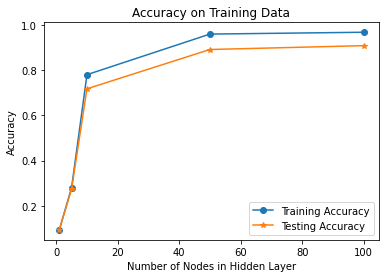

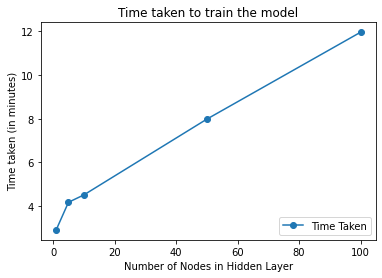

In [60]:
plotData(nodeValues,res)

## PART C

In [61]:
nodeValues = [1,5,10,50,100]
data = (True,0.5,1e-8,2000,trainX,trainY,testX,testY)
try:
    st = time()
    pickle_in = open("/content/drive/My Drive/Colab Notebooks/alphabet/Partc.pickle","rb")
    res = pickle.load(pickle_in)
    print(time()-st)
except:
    st = time()
    res = Parallel(n_jobs=-2)(delayed(trainNetwork)(i,data) for i in nodeValues)
    print(time()-st)
    with open("/content/drive/My Drive/Colab Notebooks/alphabet/Partc.pickle","wb") as f:
        pickle.dump(res,f)

0.0012333393096923828


In [62]:
res

[(3.189598798751831, 34, 0.05615384615384615, 0.05507692307692308),
 (99.8906557559967, 801, 0.05984615384615385, 0.06323076923076923),
 (267.27183055877686, 2001, 0.36530769230769233, 0.36323076923076925),
 (473.627224445343, 2001, 0.8903846153846153, 0.8596923076923076),
 (697.4859735965729, 2001, 0.8951538461538462, 0.8616923076923076)]

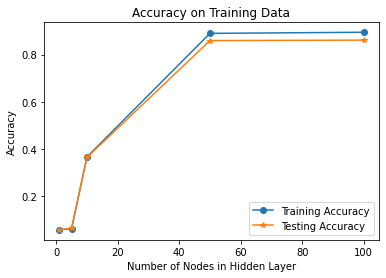

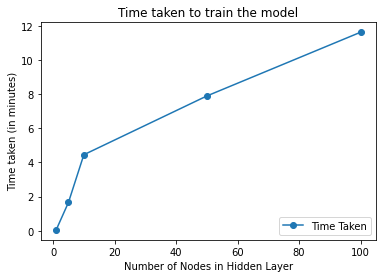

In [63]:
plotData(nodeValues,res)

## PART D

In [0]:
nn = NeuralNetwork(100,784,[100,100],26,eta=0.5,adaptiveLearning=True,activation="relu",weight_init="random")

In [65]:
nn.fit(trainX,trainY)
print("Training Score on Relu Activation:",nn.score(trainX,trainY))
print("Testing Score on Relu Activation:",nn.score(testX,testY))

Training Score on Relu Activation: 0.9347692307692308
Testing Score on Relu Activation: 0.8801538461538462


In [0]:
nn = NeuralNetwork(100,784,[100,100],26,eta=0.5,adaptiveLearning=True,activation="sigmoid",weight_init="random")

In [67]:
nn.fit(trainX,trainY)
print("Training Score on Sigmoid Activation:",nn.score(trainX,trainY))
print("Testing Score on Sigmoid Activation:",nn.score(testX,testY))

Training Score on Sigmoid Activation: 0.8421538461538461
Testing Score on Sigmoid Activation: 0.8152307692307692


## PART E


In [0]:
oneHotYTrain = createOneHot(trainY,26)
oneHotYTest = createOneHot(testY,26)

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100),activation='logistic',solver='sgd',learning_rate_init=0.5,learning_rate="invscaling",batch_size=100,max_iter=2000,alpha=0,momentum=0)

In [0]:
mlp.fit(trainX,oneHotYTrain)
print("Training Score:",score(mlp.predict_proba(trainX),trainY))
print("Testing Score:",score(mlp.predict_proba(testX),testY))
print("Train and Test scores for one hot vectors:")
print(mlp.score(trainX,oneHotYTrain),mlp.score(testX,oneHotYTest))

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100),activation='relu',solver='sgd',learning_rate_init=0.5,learning_rate="invscaling",batch_size=100,alpha=0,momentum=0,max_iter=2000)

In [0]:
mlp.fit(trainX,oneHotYTrain)
print("Training Score:",score(mlp.predict_proba(trainX),trainY))
print("Testing Score:",score(mlp.predict_proba(testX),testY))
print("Train and Test scores for one hot vectors:")
print(mlp.score(trainX,oneHotYTrain),mlp.score(testX,oneHotYTest))

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100),activation='logistic',solver='sgd',learning_rate_init=0.1,learning_rate="invscaling",batch_size=100,max_iter=2000,alpha=0,momentum=0)

In [0]:
mlp.fit(trainX,oneHotYTrain)
print("Training Score (Logistic):",score(mlp.predict_proba(trainX),trainY))
print("Testing Score (Logistic):",score(mlp.predict_proba(testX),testY))
print("Train and Test scores for one hot vectors:")
print(mlp.score(trainX,oneHotYTrain),mlp.score(testX,oneHotYTest))

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100),activation='relu',solver='sgd',learning_rate_init=0.1,learning_rate="invscaling",batch_size=100,alpha=0,momentum=0,max_iter=2000)

In [0]:
mlp.fit(trainX,oneHotYTrain)
print("Training Score (Relu):",score(mlp.predict_proba(trainX),trainY))
print("Testing Score (Relu):",score(mlp.predict_proba(testX),testY))
print("Train and Test scores for one hot vectors:")
print(mlp.score(trainX,oneHotYTrain),mlp.score(testX,oneHotYTest))

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100),activation='logistic',solver='sgd',learning_rate_init=0.5,learning_rate="adaptive",batch_size=100,max_iter=2000,alpha=0,momentum=0)

In [0]:
mlp.fit(trainX,oneHotYTrain)
print("Training Score (Logistic):",score(mlp.predict_proba(trainX),trainY))
print("Testing Score (Logistic):",score(mlp.predict_proba(testX),testY))
print("Train and Test scores for one hot vectors:")
print(mlp.score(trainX,oneHotYTrain),mlp.score(testX,oneHotYTest))

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100),activation='relu',solver='sgd',learning_rate_init=0.5,learning_rate="adaptive",batch_size=100,max_iter=2000,alpha=0,momentum=0)

In [0]:
mlp.fit(trainX,oneHotYTrain)
print("Training Score (Relu):",score(mlp.predict_proba(trainX),trainY))
print("Testing Score (Relu):",score(mlp.predict_proba(testX),testY))
print("Train and Test scores for one hot vectors:")
print(mlp.score(trainX,oneHotYTrain),mlp.score(testX,oneHotYTest))

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100),activation='logistic',solver='sgd',learning_rate_init=0.5,learning_rate="invscaling",batch_size=100,max_iter=2000,alpha=0,momentum=0)

In [0]:
mlp.fit(trainX,trainY)
print("Training and Testing scores for Sigmoid (when MLP uses softmax as output layer)")
print(mlp.score(trainX,trainY),mlp.score(testX,testY))

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100),activation='relu',solver='sgd',learning_rate_init=0.5,learning_rate="invscaling",batch_size=100,max_iter=2000,alpha=0,momentum=0)

In [0]:
mlp.fit(trainX,trainY)
print("Training and Testing scores for Relu (when MLP uses softmax as output layer)")
print(mlp.score(trainX,trainY),mlp.score(testX,testY))